In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
from scipy.special import expit
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [5]:
file_name = './historic_data/BTC-USD_300_200173.csv'
window = 288 # 1 day
# Read csv, use Time column as a datetime index, and sort by this index
df = pd.read_csv(file_name, index_col='Time', parse_dates=True, infer_datetime_format=True).sort_index()
# Resample the data to a longer time interval, keeping the OHLCV data correct
#df = df.resample('15Min').apply({'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last', 'Volume' : 'sum'})
# Calculate the Oracle stance
df['Stance'] = df['Close'].rolling(window=window,center=True).mean().diff().rolling(window=window,center=True).mean()
# https://stackoverflow.com/questions/31287552/logarithmic-returns-in-pandas-dataframe
#df['CloseGrossReturn'] = df['Close'].pct_change()
df['CloseLogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
# Scale a column to have variance of 1, do not shift the mean
#df['CloseReturnVNorm'] = scale(df['CloseLogReturn'].values, with_mean=False)
#df['CloseReturnMMNorm'] = minmax_scale(df['CloseLogReturn'].values, feature_range=(0, 1))
#df['CloseReturnRNorm'] = robust_scale(df['CloseLogReturn'].values, with_centering=False)

#df['VolumeMMNorm'] = minmax_scale(df['Volume'].values, feature_range=(0, 1))
#df['StanceVNorm'] = scale(df['Stance'].values, with_mean=False)
#df['StanceMMNorm'] = minmax_scale(df['Stance'].values, feature_range=(0, 1))

df['StanceTanh'] = np.tanh(df['Stance'])
df['VolumnSigm'] = expit(df['Volume'])

# Create categorical columns from some aspect of the time
df = pd.concat([df, pd.get_dummies(df.index.weekday, prefix='DayOfWeek').set_index(df.index)], axis=1)
df = pd.concat([df, pd.get_dummies(df.index.hour, prefix='HourOfDay').set_index(df.index)], axis=1)
#df.dropna(inplace=True)
#df[-7000:-6000].plot(y=['StanceMMNorm', 'CloseReturnMMNorm', 'VolumeMMNorm'], secondary_y=['CloseReturnMMNorm'], figsize=(15, 5), grid=True)
#df[-6500:-6000].plot(y=['StanceVNorm', 'CloseReturnRNorm', 'VolumeMMNorm'],figsize=(15, 5), grid=True)

df.describe()

Low           High           Open          Close  \
count  200173.000000  200173.000000  200173.000000  200173.000000   
mean     5751.975625    5769.119069    5760.906018    5760.925925   
std      3869.464324    3887.074864    3878.595236    3878.548711   
min         0.060000     748.440000       0.060000     746.610000   
25%      2359.610000    2369.000000    2364.120000    2364.110000   
50%      6305.280000    6315.000000    6309.860000    6309.900000   
75%      7853.000000    7880.450000    7866.720000    7866.720000   
max     19890.990000   19891.990000   19891.990000   19891.980000   

              Volume         Stance  CloseLogReturn     StanceTanh  \
count  200173.000000  199598.000000   200172.000000  199598.000000   
mean       48.578258       0.027821        0.000010       0.031063   
std        78.463278       1.140054        0.003223       0.489230   
min         0.000001      -8.424427       -0.210212      -1.000000   
25%        12.029536      -0.222282       -0.000751      -0.218692   
50%        25.426737       0.036209        0.000000       0.036194   
75%        54.035212       0.316492        0.000858       0.306331   
max      2514.557264      10.149591        0.102285       1.000000   

          VolumnSigm    DayOfWeek_0      ...         HourOfDay_14  \
count  200173.000000  200173.000000      ...        200173.000000   
mean        0.994118       0.142352      ...             0.041754   
std         0.033663       0.349412      ...             0.200027   
min         0.500000       0.000000      ...             0.000000   
25%         0.999994       0.000000      ...             0.000000   
50%         1.000000       0.000000      ...             0.000000   
75%         1.000000       0.000000      ...             0.000000   
max         1.000000       1.000000      ...             1.000000   

        HourOfDay_15   HourOfDay_16   HourOfDay_17   HourOfDay_18  \
count  200173.000000  200173.000000  200173.000000  200173.000000   
mean        0.041789       0.041814       0.041789       0.041839   
std         0.200107       0.200164       0.200107       0.200221   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

        HourOfDay_19   HourOfDay_20   HourOfDay_21   HourOfDay_22  \
count  200173.000000  200173.000000  200173.000000  200173.000000   
mean        0.041704       0.041629       0.041649       0.041679   
std         0.199912       0.199740       0.199786       0.199855   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

        HourOfDay_23  
count  200173.000000  
mean        0.041729  
std         0.199970  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 40 columns]

In [6]:
cols = ['CloseLogReturn', 'VolumnSigm']

X1=np.array(df['CloseLogReturn'])
X2=np.array(df['VolumnSigm'])

Y=np.array(df['StanceTanh'])

sequence_length = 288 * 7 # One Week
test_periods = 4

x1_data = X1[:(len(X1) - test_periods * sequence_length - (len(X1) % sequence_length))]
x2_data = X2[:(len(X2) - test_periods * sequence_length - (len(X2) % sequence_length))]
x_data = np.dstack([x1_data, x2_data])

x_batches = x_data.reshape(-1, sequence_length, 2)

y_data = Y[:(len(Y) - test_periods * sequence_length - (len(Y) % sequence_length))]
y_batches = y_data.reshape(-1, sequence_length, 1)

print(x_batches.shape)
print(y_batches.shape)

(95, 2016, 2)
(95, 2016, 1)


In [7]:
testX1 = X1[-(test_periods*sequence_length):]
testX2 = X2[-(test_periods*sequence_length):]
testX = np.dstack([testX1, testX2]).reshape(-1, sequence_length, 2)
testY = Y[-(test_periods*sequence_length):].reshape(-1, sequence_length, 1)
print(testX.shape)
print(testY.shape)

(4, 2016, 2)
(4, 2016, 1)


In [8]:
tf.reset_default_graph()

input_s = 2
hidden = 512
output_s = 1
learning_rate = 0.001

x = tf.placeholder(tf.float32, [None, sequence_length, input_s])
y = tf.placeholder(tf.float32, [None, sequence_length, output_s])

basic_cell = tf.nn.rnn_cell.LSTMCell(num_units=hidden)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)
rnn_output = tf.reshape(rnn_output, [-1, hidden])
outputs = tf.layers.dense(rnn_output, output_s)
outputs = tf.reshape(outputs, [-1, sequence_length, output_s])

loss = tf.losses.mean_squared_error(y, outputs)
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimiser.minimize(loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [ ]:
epochs = 10

checkpoint_path = "/home/richie/repo/twisty/dev/notebooks/cpts/512u80000p.ckpt"
continue_training = False

with tf.Session() as sess:
    init.run()
    if continue_training and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
        print("Model {} restored.".format(checkpoint_path))
    for ep in range(epochs):
        _, train_loss = sess.run((training_op, loss), feed_dict={x: x_batches, y: y_batches})
        if ep % 10 == 0:
            mse = loss.eval(feed_dict={x: testX, y: testY})
            print("{}\tTrain Loss: {}\tTest Loss: {}".format(ep, train_loss * 4, mse * 35))
            save_path = saver.save(sess, checkpoint_path)
            
    # Save the variables to disk.
    save_path = saver.save(sess, checkpoint_path)
    print("Model saved in path: %s" % save_path)

In [160]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, checkpoint_path)
    mse = loss.eval(feed_dict={x: testX, y: testY})
    print("Model restored. MSE:", mse)
    #ytrained = sess.run(outputs, feed_dict={x: x_batches})
    ypred = sess.run(outputs, feed_dict={x: testX})
    

INFO:tensorflow:Restoring parameters from /home/richie/repo/twisty/dev/notebooks/cpts/512u80000p.ckpt
Model restored. MSE: 0.029244956


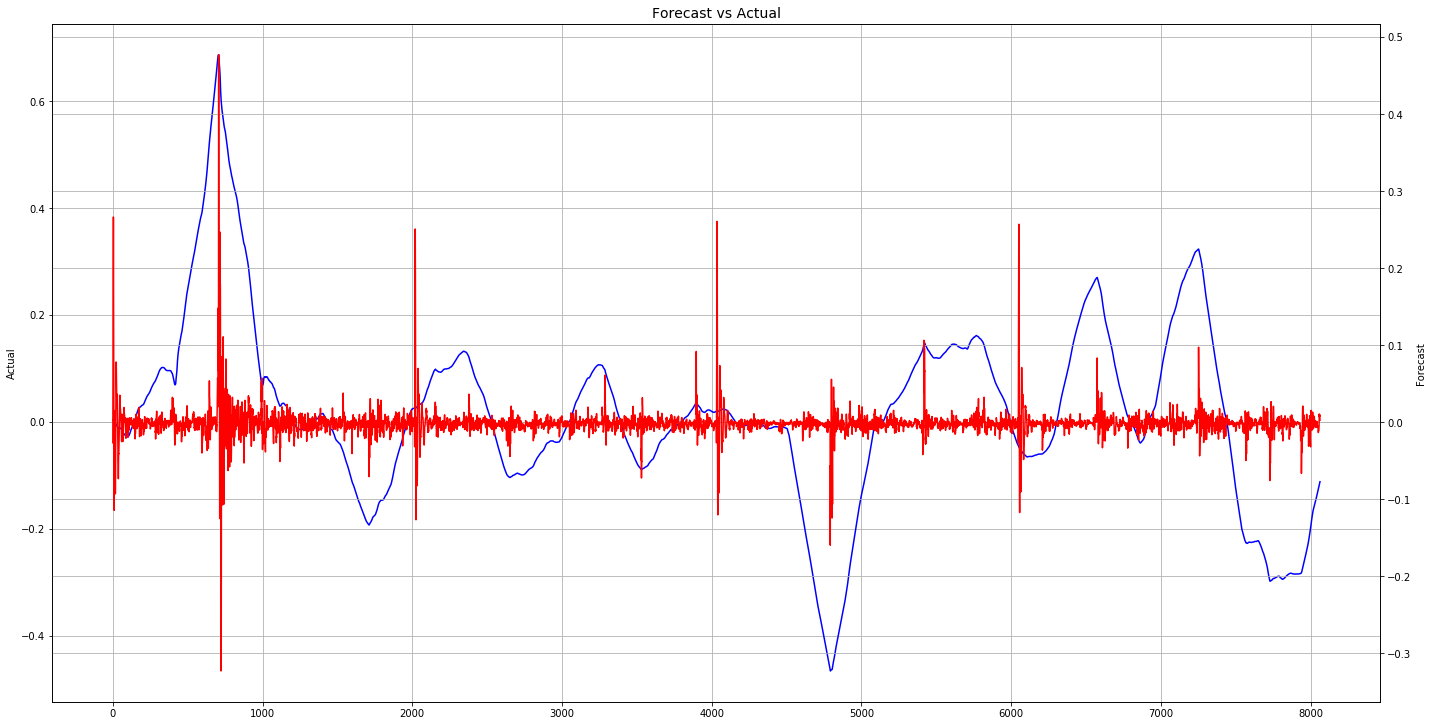

In [161]:
#https://matplotlib.org/examples/api/two_scales.html
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.plot(pd.Series(np.ravel(testY)), 'b-')
ax1.set_ylabel("Actual")
ax1.grid()
ax2 = ax1.twinx()
ax2.plot(pd.Series(np.ravel(ypred)), 'r-')
ax2.set_ylabel("Forecast")

fig.tight_layout()
plt.title("Forecast vs Actual", fontsize=14)
#plt.legend(loc="upper right")
plt.xlabel("Time")
plt.grid()

plt.show()

In [162]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_batches)), label="Actual")
plt.plot(pd.Series(np.ravel(ytrained)), label="Forecast")
plt.legend(loc="upper right")
plt.xlabel("Time")
plt.grid()

plt.show()